In [5]:
import sys, os, time, math
import functools
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [6]:
def estimate_expectation(data):
    estimate = torch.mean(data)
    return estimate

def generate_observations(dist_u, dist_z, dist_x, dist_y, alpha1, alpha2, beta, gamma, n):
    eps_u = dist_u.sample([n])
    eps_z = dist_z.sample([n])
    eps_x = dist_x.sample([n])
    eps_y = dist_y.sample([n])

    eps_u -= estimate_expectation(eps_u)
    eps_z -= estimate_expectation(eps_z)
    eps_x -= estimate_expectation(eps_x)
    eps_y -= estimate_expectation(eps_y)

    Z = eps_u*alpha1 + eps_z
    X = eps_u*alpha2 + eps_x
    Y = X*beta + eps_u*gamma + eps_y
    return (Z, X, Y)

In [7]:
def compute_alpha(Z, X, max_m=6):
    deg_m = 2
    var_u = estimate_expectation(Z*X)
    alpha2 = None
    alpha_estimations = []
    
    while deg_m<max_m:
        diff_normal_X = estimate_expectation(X**(deg_m)*Z) - deg_m*var_u*estimate_expectation(X**(deg_m-1))
        diff_normal_Z = estimate_expectation(Z**(deg_m)*X) - deg_m*var_u*estimate_expectation(Z**(deg_m-1))
        
        alpha_sq = ((diff_normal_X) / (diff_normal_Z))
        if alpha_sq < 0:
            alpha_sq = -(abs(alpha_sq)**(1/(deg_m-1)))
        else:
            alpha_sq = alpha_sq**(1/(deg_m-1))
        alpha_estimations.append((alpha_sq, deg_m))
        deg_m += 1
    
    return alpha_estimations

def compute_beta(Z, X, Y, alpha_sq):
    numerator = estimate_expectation(X*Y) - alpha_sq*estimate_expectation(Y*Z)
    denominator = estimate_expectation(X*X) - alpha_sq*estimate_expectation(X*Z)
    return numerator / denominator

In [8]:
confidence = 10
n_list = list(range(100, 100000, 1000))
max_m = 6
alpha1 = 0
alpha2 = 0
seed = np.random.randint(1000)
while abs(alpha1) < 0.2 or abs(alpha2) < 0.2 or abs(beta_true) < 0.5 or abs(gamma) < 0.5:
    alpha1 = -2 + 4 * np.random.rand()
    alpha2 = -2 + 4 * np.random.rand()
    beta_true = -5 + 10 * np.random.rand()
    gamma = -5 + 10 * np.random.rand()
print("True values:")
print("alpha1: ", alpha1)
print("alpha2: ", alpha2)
print("beta: ", beta_true)
print("gamma: ", gamma)

True values:
alpha1:  -1.2093232001219563
alpha2:  0.647056817785427
beta:  4.140770963698573
gamma:  0.7345063446993825


In [9]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
betas_exp = {}
for n in n_list:
    for i in range(confidence):
        dist_u = torch.distributions.exponential.Exponential(1/2)
        dist_x = torch.distributions.exponential.Exponential(1/2)
        dist_z = torch.distributions.exponential.Exponential(1/2)
        dist_y = torch.distributions.exponential.Exponential(1/2) 

        Z, X, Y = generate_observations(dist_u, dist_z, dist_x, dist_y, alpha1, alpha2, beta_true, gamma, n)

        alpha_estimations = compute_alpha(Z, X, max_m)
        for (alpha_sq, deg) in alpha_estimations:
            if deg not in betas_exp.keys():
                betas_exp[deg] = []
            beta = compute_beta(Z, X, Y, alpha_sq)
            if i == 0:
                betas_exp[deg].append(beta)
            elif i == (confidence - 1):
                betas_exp[deg][-1] += beta
                betas_exp[deg][-1] /= confidence
            else:
                betas_exp[deg][-1] += beta

In [10]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
betas_normal = {}
for n in n_list:
    beta = 0
    for i in range(confidence):
        dist_u = torch.distributions.normal.Normal(0, 1)
        dist_x = torch.distributions.normal.Normal(0, 1)
        dist_z = torch.distributions.normal.Normal(0, 1)
        dist_y = torch.distributions.normal.Normal(0, 1)

        Z, X, Y = generate_observations(dist_u, dist_z, dist_x, dist_y, alpha1, alpha2, beta_true, gamma, n)

        alpha_estimations = compute_alpha(Z, X, max_m)
        for (alpha_sq, deg) in alpha_estimations:
            if deg not in betas_normal.keys():
                betas_normal[deg] = []
            beta = compute_beta(Z, X, Y, alpha_sq)
            if i == 0:
                betas_normal[deg].append(beta)
            elif i == (confidence - 1):
                betas_normal[deg][-1] += beta
                betas_normal[deg][-1] /= confidence
            else:
                betas_normal[deg][-1] += beta

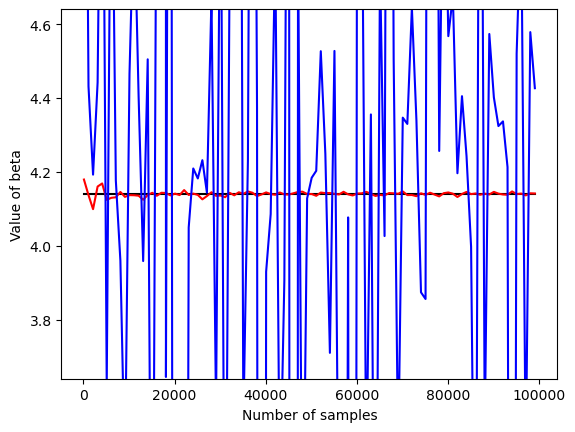

In [11]:
epsilon = 0.5
deg_target = 2
x_val = np.array(n_list)
y_val_exp = np.array(betas_exp[deg_target])
y_val_normal = np.array(betas_normal[deg_target])
y_val_true = np.zeros_like(y_val_exp) + beta_true

plt.plot(x_val, y_val_true, color="black")
plt.plot(x_val, y_val_exp, color="red")
plt.plot(x_val, y_val_normal, color="blue")
plt.xlabel("Number of samples")
plt.ylabel(f"Value of beta")
plt.ylim(beta_true-epsilon, beta_true+epsilon)
plt.show()

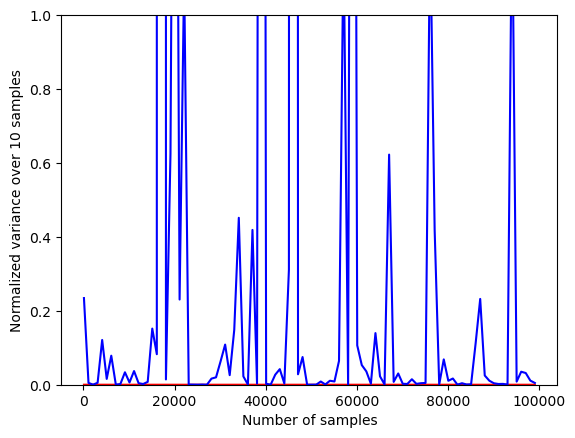

In [12]:
deg_target = 2
x_val = np.array(n_list)
y_val_exp = (np.array(betas_exp[deg_target]) - beta_true)**2 / beta_true**2
y_val_normal = (np.array(betas_normal[deg_target]) - beta_true)**2 / beta_true**2

plt.plot(x_val, y_val_exp, color="red")
plt.plot(x_val, y_val_normal, color="blue")
plt.xlabel("Number of samples")
plt.ylabel(f"Normalized variance over {confidence} samples")
plt.ylim(0, 1)
plt.show()